# Signal Autoencoder

In [ ]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init
import sys
sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel

In [48]:
####MAF 
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(16, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 48),
            nn.LeakyReLU(True),            
            nn.Linear(48, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 48),
            nn.LeakyReLU(True),
            nn.Linear(48, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 16)
        )
        
        flow_init = MAF(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

In [49]:
prong_2 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/delphes_output_5000_850_450.h5")
#prong_3 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5")

In [50]:
columns = prong_2.columns

In [51]:
columns

Index(['Mjj', 'j1 pT', 'j2 pT', 'Mj1', 'j1 tau21', 'j1 tau32', 'j1 tau43',
       'j1 tau54', 'j1 tau65', 'j1 tau76', 'j1 tau87',
       'j1 sqrt(tau^2_1)/tau^1_1', 'j1 n_trk', 'j1 M_trim', 'j1 M_prun',
       'j1 M_mmdt', 'j1 M_sdb1', 'j1 M_sdb2', 'j1 M_sdm1', 'Mj2', 'j2 tau21',
       'j2 tau32', 'j2 tau43', 'j2 tau54', 'j2 tau65', 'j2 tau76', 'j2 tau87',
       'j2 sqrt(tau^2_1)/tau^1_1', 'j2 n_trk', 'j2 M_trim', 'j2 M_prun',
       'j2 M_mmdt', 'j2 M_sdb1', 'j2 M_sdb2', 'j2 M_sdm1'],
      dtype='object')

In [52]:
dt = prong_2.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0) &(dt[:,2]>0) & (dt[:,16]>0) & (dt[:,32]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])


correct = (dt[:,16]>0) & (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]


#Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
#Y = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]] # When no jet 1,2 raw mass included
#Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
#idx = dt[:,-1]
#bkg_idx = np.where(idx==0)[0]
#signal_idx = np.where((idx==1) & (dt[:,3]>300))[0]
#signal_idx = np.where((idx==1)) [0]
#dt = dt[signal_idx]
    
bsmlike = np.where(dt[:,16]>0.9)[0]
dt = dt[bsmlike]


In [53]:
dt.shape

(70215, 35)

In [54]:
j1sdb = dt[:,3]*dt[:,16]
j2sdb = dt[:,19]*dt[:,32]

pt = dt[:,1]
m = j1sdb[:]
m2 = j2sdb[:]
tau21 = dt[:,4]
tau32 = dt[:,5]
tau43 = dt[:,6]
tau54 = dt[:,7]
tau65 = dt[:,8]
massratio = dt[:,16]

rho = np.log((m*m)/(pt*pt))
rhoprime = np.log((m*m)/(pt*1))

tau21prime = tau21 + rhoprime * 0.088
tau32prime = tau32 + rhoprime * 0.025
tau43prime = tau43 + rhoprime * 0.01
tau54prime = tau54 + rhoprime * 0.001
j2pt = dt[:,2]
#m = j1sdb[mrange]
j2m = j2sdb[:]
j2tau21 = dt[:,20]
j2tau32 = dt[:,21]
j2tau43 = dt[:,22]
j2tau54 = dt[:,23]
j2tau65 = dt[:,24]
j2massratio = dt[:,32]


j2rho = np.log((j2m*j2m)/(j2pt*j2pt))
j2rhoprime = np.log((j2m*j2m)/(j2pt*1))

j2tau21prime = j2tau21 + j2rhoprime * 0.086
j2tau32prime = j2tau32 + j2rhoprime * 0.025
j2tau43prime = j2tau43 + j2rhoprime * 0.01
j2tau54prime = j2tau54 + j2rhoprime * 0.001

In [55]:
dt[:,4] = tau21prime
dt[:,5] = tau32prime
dt[:,6] = tau43prime
dt[:,7] = tau54prime

dt[:,20] = j2tau21prime 
dt[:,21] = j2tau32prime
dt[:,22] = j2tau43prime
dt[:,23] = j2tau54prime

In [56]:
columns[19]

'Mj2'

In [57]:
m1minusm2 = dt[:,3] - dt[:,19] 

dt[:,19] = m1minusm2

In [58]:
Y = dt[:,[3,4,5,6,7,8,11,12,19,20,21,22,23,24,27,28]]

In [59]:
Y.shape

(70215, 16)

In [60]:
#if nprong == 3:
#    dt = prong_3.values
#    correct = (dt[:,3]>20) &(dt[:,19]>20)
#    dt = dt[correct]
#    for i in range(13,19):
#        dt[:,i] = dt[:,i]/dt[:,3]
    
#    for i in range(29,35):
#        dt[:,i] = dt[:,i]/(dt[:,19])
        
#    correct = (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
#    dt = dt[correct]        
        
#    Y = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]]
#    #Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
#    idx = dt[:,-1]
#    bkg_idx = np.where(idx==0)[0]
#    signal_idx = np.where((idx==1) & (dt[:,3]>400))[0]
#    #signal_idx = np.where((idx==1)) [0]
#    Y = Y[signal_idx]

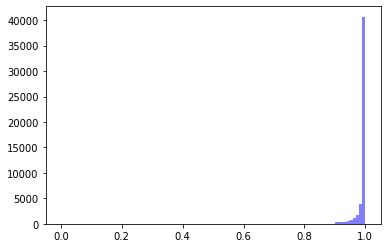

In [61]:
bins = np.linspace(0,1,100)
bins.shape
column = 5
#print(f_rnd.columns[column])
plt.hist(dt[:,16],bins,alpha=0.5,color='b');
#plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
#plt.axvline(np.mean(Y[:,column]))

In [62]:
Y.shape

(70215, 16)

In [63]:
sig_mean = []
sig_std = []
for i in range(16):
    mean = np.mean(Y[:,i])
    std = np.std(Y[:,i])
    sig_mean.append(mean)
    sig_std.append(std)
    Y[:,i] = (Y[:,i]-mean)/std

In [64]:
sig_mean

[560.4673635325017,
 0.6485325941694001,
 0.7615410018376673,
 0.8233203751705781,
 0.8411926223162028,
 0.8693572840928546,
 1.3506804981097114,
 263.17014882859786,
 299.31868089997874,
 0.6289354771347945,
 0.7452559492605366,
 0.8079707935585495,
 0.8345289568434062,
 0.8573591442105765,
 2.080603443794753,
 202.98768069500818]

In [65]:
sig_std

[206.2951136688244,
 0.13161705980546703,
 0.15471586646041038,
 0.09993416909916117,
 0.07031005801722459,
 0.053408762199321023,
 0.33406801313127116,
 98.30551936092819,
 135.74319632008635,
 0.17483708043001006,
 0.13834978793550337,
 0.09744719468099658,
 0.07300203939568409,
 0.06254134730913442,
 1.126024138656687,
 90.86766295216417]

In [66]:
total_sig = torch.tensor(Y)

In [67]:
total_sig.shape

torch.Size([70215, 16])

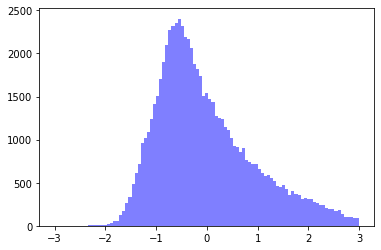

In [68]:
bins = np.linspace(-3,3,100)
bins.shape
column = 5
#print(f_rnd.columns[column])
plt.hist(Y[:,1],bins,alpha=0.5,color='b');
#plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
#plt.axvline(np.mean(Y[:,column]))

In [69]:
N_EPOCHS = 30
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-6

#N_FLOWS = 6 
#Z_DIM = 8

N_FLOWS = 10
Z_DIM = 6

n_steps = 0

In [70]:
sigmodel = VAE_NF(N_FLOWS, Z_DIM).cuda()

In [71]:
print(sigmodel)

VAE_NF(
  (encoder): Sequential(
    (0): Linear(in_features=16, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=50, out_features=48, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=48, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=48, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=48, out_features=50, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=50, out_features=16, bias=True)
  )
  (flows): NormalizingFlowModel(
    (flows): ModuleList(
      (0): MAF(
        (layers): ModuleList(
          (0): FCNN(
            (network): Sequential(
              (0): Linear(in_features=1, out_features=8, bias=True)
              (1): Tanh()
              (2): Linear(in_features=8, out_features=8, bias=True)
              (3): Tanh()
              (4): Linear(in_features=8, out_features=2, bias=True)

In [72]:
bs = 800
sig_train_iterator = utils.DataLoader(total_sig, batch_size=bs, shuffle=True) 
sig_test_iterator = utils.DataLoader(total_sig, batch_size=bs)

In [98]:
sigoptimizer = optim.Adam(sigmodel.parameters(), lr=1e-6)

In [99]:
beta = 1

In [100]:
def sigtrain():
    global n_steps
    train_loss = []
    sigmodel.train()

    for batch_idx, x in enumerate(sig_train_iterator):
        start_time = time.time()
        
        x = x.float().cuda()

        x_tilde, kl_div = sigmodel(x)
        mseloss = nn.MSELoss(size_average=False)
        huberloss = nn.SmoothL1Loss(size_average=False)
        #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
        loss_recons = mseloss(x_tilde,x ) / x.size(0)
        #loss_recons = huberloss(x_tilde,x ) / x.size(0)
        loss = loss_recons + beta* kl_div

        sigoptimizer.zero_grad()
        loss.backward()
        sigoptimizer.step()

        train_loss.append([loss_recons.item(), kl_div.item()])

        if (batch_idx + 1) % PRINT_INTERVAL == 0:
            print('\tIter [{}/{} ({:.0f}%)]\tLoss: {} Time: {:5.3f} ms/batch'.format(
                batch_idx * len(x), 50000,
                PRINT_INTERVAL * batch_idx / 50000,
                np.asarray(train_loss)[-PRINT_INTERVAL:].mean(0),
                1000 * (time.time() - start_time)
            ))

        n_steps += 1

In [101]:
def sigevaluate(split='valid'):
    global n_steps
    start_time = time.time()
    val_loss = []
    sigmodel.eval()

    with torch.no_grad():
        for batch_idx, x in enumerate(sig_test_iterator):
            
            x = x.float().cuda()

            x_tilde, kl_div = sigmodel(x)
            mseloss = nn.MSELoss(size_average=False)
            huberloss = nn.SmoothL1Loss(size_average=False)
            #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            loss_recons = mseloss(x_tilde,x ) / x.size(0)
            #loss_recons = huberloss(x_tilde,x ) / x.size(0)
            loss = loss_recons + beta * kl_div

            val_loss.append(loss.item())
            #writer.add_scalar('loss/{}/ELBO'.format(split), loss.item(), n_steps)
            #writer.add_scalar('loss/{}/reconstruction'.format(split), loss_recons.item(), n_steps)
            #writer.add_scalar('loss/{}/KL'.format(split), kl_div.item(), n_steps)

    print('\nEvaluation Completed ({})!\tLoss: {:5.4f} Time: {:5.3f} s'.format(
        split,
        np.asarray(val_loss).mean(0),
        time.time() - start_time
    ))
    return np.asarray(val_loss).mean(0)

In [102]:
ae_def = {
    "type":"sig",
    "trainon":"BB2refined",
    "features":"tauDDTwithm1andm1minusm2",
    "architecture":"MAF",
    "selection":"turnoncutandj1sdbcut0p9",
    "trainloss":"MSELoss",
    "beta":"beta1",
    "zdimnflow":"z6f10",
}

In [103]:
ae_def

{'type': 'sig',
 'trainon': 'BB2refined',
 'features': 'tauDDTwithm1andm1minusm2',
 'architecture': 'MAF',
 'selection': 'turnoncutandj1sdbcut0p9',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z6f10'}

In [105]:
N_EPOCHS = 10
BEST_LOSS = 99
LAST_SAVED = -1
PATIENCE_COUNT = 0
PATIENCE_LIMIT = 5
for epoch in range(1, 1000):
    print("Epoch {}:".format(epoch))
    sigtrain()
    cur_loss = sigevaluate()

    if cur_loss <= BEST_LOSS:
        PATIENCE_COUNT = 0
        BEST_LOSS = cur_loss
        LAST_SAVED = epoch
        print("Saving model!")
        torch.save(sigmodel.state_dict(),f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}.h5")
        
    else:
        PATIENCE_COUNT += 1
        print("Not saving model! Last saved: {}".format(LAST_SAVED))
        if PATIENCE_COUNT > 10:
            print("Patience Limit Reached")
            break 

Epoch 1:

Evaluation Completed (valid)!	Loss: -47.8154 Time: 1.032 s
Saving model!
Epoch 2:

Evaluation Completed (valid)!	Loss: -47.4503 Time: 1.031 s
Not saving model! Last saved: 1
Epoch 3:

Evaluation Completed (valid)!	Loss: -47.8960 Time: 1.031 s
Saving model!
Epoch 4:

Evaluation Completed (valid)!	Loss: -47.8303 Time: 1.030 s
Not saving model! Last saved: 3
Epoch 5:

Evaluation Completed (valid)!	Loss: -47.9257 Time: 1.049 s
Saving model!
Epoch 6:

Evaluation Completed (valid)!	Loss: -48.0082 Time: 1.032 s
Saving model!
Epoch 7:

Evaluation Completed (valid)!	Loss: -48.0262 Time: 1.072 s
Saving model!
Epoch 8:

Evaluation Completed (valid)!	Loss: -48.1401 Time: 1.041 s
Saving model!
Epoch 9:

Evaluation Completed (valid)!	Loss: -48.1069 Time: 1.042 s
Not saving model! Last saved: 8
Epoch 10:

Evaluation Completed (valid)!	Loss: -48.2144 Time: 1.041 s
Saving model!
Epoch 11:

Evaluation Completed (valid)!	Loss: -48.2063 Time: 1.068 s
Not saving model! Last saved: 10
Epoch 12:

E

KeyboardInterrupt: 

In [106]:
sigmodel.load_state_dict(torch.load(f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}.h5"))

<All keys matched successfully>

In [107]:
sigout = sigmodel(torch.tensor(Y).float().cuda())[0]
sigout = sigout.data.cpu().numpy()

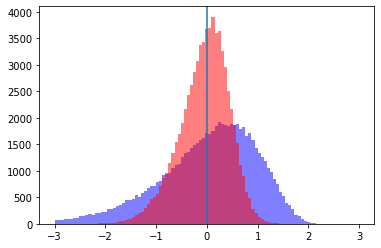

In [112]:
bins = np.linspace(-3,3,100)
bins.shape
column = 3
#print(f_rnd.columns[column]
plt.hist(Y[:,column],bins,alpha=0.5,color='b');
plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
plt.axvline(np.mean(Y[:,column]))

In [117]:
inputlist = [
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_background.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5', 
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5' 
]

In [118]:
ae_def

{'type': 'sig',
 'trainon': 'BB2refined',
 'features': 'tauDDTwithm1andm1minusm2',
 'architecture': 'MAF',
 'selection': 'turnoncutandj1sdbcut0p9',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z6f10'}

In [119]:
outputlist_waic = [
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb1.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb2.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb3.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_purebkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_rndbkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_2prong.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_3prong.npy",
]

outputlist_justloss = [
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb1.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb2.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb3.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_rndbkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_2prong.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_3prong.npy",
]

In [120]:
exist_signalflag = [
    False,
    False,
    False,
    False,
    True,
    True,
    True,
]
is_signal = [
    False,
    False,
    False,
    False,
    False,
    True,
    True
]

nprong = [
    None,
    None,
    None,
    None,
    None,
    '2prong',
    '3prong'
]

(239348, 16)
[0.5621231  0.7257408  1.5456731  4.4727592  1.7192183  0.63712144
 0.87706244 1.4546484  1.1553826  0.7346349 ]
(242090, 16)
[2.198793   1.2428405  0.40043712 0.8065294  1.3725975  0.74437785
 1.089239   3.7420623  0.6250814  5.131377  ]
(231654, 16)
[1.4239047  1.2951014  1.4519202  1.830255   0.85408366 2.79452
 0.6290309  3.7436433  0.7428176  0.77418315]
(232418, 16)
[1.6825635  0.68195534 1.64975    0.54647213 0.86837137 1.2845922
 0.64988124 6.31655    0.72260743 3.52882   ]
(263134, 16)
[2.3111129 1.1483724 1.552469  1.1572509 0.7856333 1.0748676 2.098085
 1.0541561 8.431256  0.9474761]
(55539, 16)
[1.2590189  0.34811112 1.9349219  2.5537033  0.9885986  0.46951413
 1.0730138  0.8460488  1.9784346  1.7014263 ]
(56525, 16)
[ 0.5981696  19.111599    0.5106672   1.0296744   1.4274571   1.2144661
  0.87782335  0.80631435  2.2813685   0.97662854]


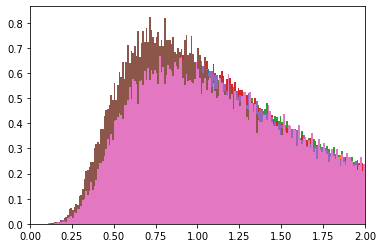

In [124]:
for in_file, out_file_waic, out_file_justloss, sigbit_flag, is_sig, n_prong in zip(inputlist,outputlist_waic,outputlist_justloss,exist_signalflag,is_signal, nprong):    
    
    f_bb = pd.read_hdf(in_file)
    dt = f_bb.values
    correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0) &(dt[:,2]>0) & (dt[:,16]>0) & (dt[:,32]>0)
    dt = dt[correct]
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]

    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])


    correct = (dt[:,16]>0) & (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
    dt = dt[correct]
    correct = (dt[:,3]>100)
    dt = dt[correct]

    correct = (dt[:,19]>20)
    dt = dt[correct]

    correct = (dt[:,0]>=2800)
    dt = dt[correct]

    bsmlike = np.where(dt[:,16]>0.9)[0]
    dt = dt[bsmlike]
    
    j1sdb = dt[:,3]*dt[:,16]
    j2sdb = dt[:,19]*dt[:,32]

    pt = dt[:,1]
    m = j1sdb[:]
    m2 = j2sdb[:]
    tau21 = dt[:,4]
    tau32 = dt[:,5]
    tau43 = dt[:,6]
    tau54 = dt[:,7]
    tau65 = dt[:,8]
    massratio = dt[:,16]

    rho = np.log((m*m)/(pt*pt))
    rhoprime = np.log((m*m)/(pt*1))

    tau21prime = tau21 + rhoprime * 0.088
    tau32prime = tau32 + rhoprime * 0.025
    tau43prime = tau43 + rhoprime * 0.01
    tau54prime = tau54 + rhoprime * 0.001

    j2pt = dt[:,2]
    #m = j1sdb[mrange]
    j2m = j2sdb[:]
    j2tau21 = dt[:,20]
    j2tau32 = dt[:,21]
    j2tau43 = dt[:,22]
    j2tau54 = dt[:,23]
    j2tau65 = dt[:,24]
    j2massratio = dt[:,32]


    j2rho = np.log((j2m*j2m)/(j2pt*j2pt))
    j2rhoprime = np.log((j2m*j2m)/(j2pt*1))

    j2tau21prime = j2tau21 + j2rhoprime * 0.086
    j2tau32prime = j2tau32 + j2rhoprime * 0.025
    j2tau43prime = j2tau43 + j2rhoprime * 0.01
    j2tau54prime = j2tau54 + j2rhoprime * 0.001
    
    dt[:,4] = tau21prime
    dt[:,5] = tau32prime
    dt[:,6] = tau43prime
    dt[:,7] = tau54prime

    dt[:,20] = j2tau21prime 
    dt[:,21] = j2tau32prime
    dt[:,22] = j2tau43prime
    dt[:,23] = j2tau54prime
    
    if sigbit_flag:
        idx = dt[:,-1]
        sigidx = (idx == 1)
        bkgidx = (idx == 0)
        if is_sig:
            dt = dt[sigidx]
        else:
            dt = dt[bkgidx]
            
    if n_prong == '2prong':
        correct = dt[:,3] > 300
        dt = dt[correct]
    
    if n_prong == '3prong':
        correct = dt[:,3] > 400
        dt = dt[correct]    
    
    m1minusm2 = dt[:,3] - dt[:,19] 

    dt[:,19] = m1minusm2
    Y = dt[:,[3,4,5,6,7,8,11,12,19,20,21,22,23,24,27,28]]
    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    #Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
    

        
    
            
    print(Y.shape)
    for i in range(16):
        Y[:,i] = (Y[:,i]-sig_mean[i])/sig_std[i]
    
    total_bb_test = torch.tensor(Y)
    #huberloss = nn.SmoothL1Loss(reduction='none')
    sigae_bbloss = torch.mean((sigmodel(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    bbvar = torch.var((sigmodel(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    waic = sigae_bbloss + bbvar
    #sigae_bbloss = torch.mean(huberloss(model(total_bb_test.float().cuda())[0],total_bb_test.float().cuda()),dim=1).data.cpu().numpy()
    print(waic[0:10])
    plt.hist(waic,bins=np.linspace(0,10,1001),density=True);
    plt.xlim([0,2])
    np.save(out_file_waic,waic)
    np.save(out_file_justloss,sigae_bbloss)

In [122]:
loss_prong3 = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_3prong.npy")
loss_prong2 = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_2prong.npy")
loss_purebkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy")
loss_rndbkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_rndbkg.npy")






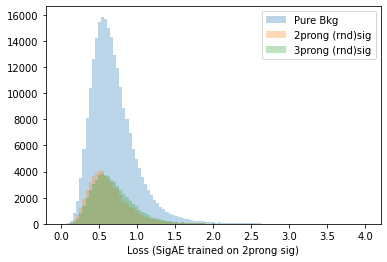

In [123]:
plt.hist(loss_purebkg,bins=np.linspace(0,4,100),density=False,alpha=0.3,label='Pure Bkg');
#plt.hist(loss_rndbkg,bins=np.linspace(0,2,100),density=False,alpha=0.3,label='(rnd) bkg');

plt.hist(loss_prong2,bins=np.linspace(0,4,100),density=False,alpha=0.3,label='2prong (rnd)sig');
plt.hist(loss_prong3,bins=np.linspace(0,4,100),density=False,alpha=0.3,label='3prong (rnd)sig');
#plt.yscale('log')
plt.xlabel('Loss (SigAE trained on 2prong sig)')
plt.legend(loc='upper right')
#plt.savefig('sigae_trained_on_2prongsig.png')

In [126]:
ae_def

{'type': 'sig',
 'trainon': 'BB2refined',
 'features': 'tauDDTwithm1andm1minusm2',
 'architecture': 'MAF',
 'selection': 'turnoncutandj1sdbcut0p9',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z6f10'}

In [44]:
len(loss_prong2)

55539

In [41]:
outputlist_waic

['../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_WAICloss_bb1.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_WAICloss_bb2.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_WAICloss_bb3.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_WAICloss_purebkg.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_WAICloss_rndbkg.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_WAICloss_2prong.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_WAICloss_3prong.npy']

In [42]:
outputlist_justloss

['../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_Justloss_bb1.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_Justloss_bb2.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_Justloss_bb3.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_Justloss_purebkg.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_Justloss_rndbkg.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_Justloss_2prong.npy',
 '../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_Justloss_3prong.npy']

In [34]:
sigae_bbloss

array([ 2832.3672,  8125.47  , 29922.496 , ...,  2359.0386,  2635.9333,
         640.2169], dtype=float32)

In [140]:
ae_def

{'type': 'sig',
 'trainon': '2prong',
 'features': 'tauDDTwithoutrawmass',
 'architecture': 'MAF',
 'selection': 'turnoncutandj1sdbcut0p9',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z6f10'}

In [141]:
sigae_bbloss

array([0.46685678, 1.5879018 , 0.58936137, ..., 0.59082854, 0.70994604,
       0.70424944], dtype=float32)

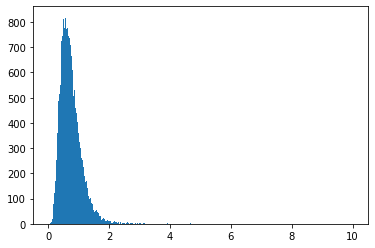

In [142]:
plt.hist(sigae_bbloss,bins=np.linspace(0,10,1001));

In [60]:
np.save('../data_strings/sigae_2prong_loss_bb3.npy',sigae_bbloss)

In [211]:
X_bkg = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
X_bkg = X_bkg[bkg_idx]

In [212]:
for i in range(12):
    X_bkg[:,i] = (X_bkg[:,i]-sig_mean[i])/sig_std[i]

In [161]:
total_bkg_test = torch.tensor(X_bkg)

In [162]:
sigae_bkgloss = torch.mean((sigmodel(total_bkg_test.float().cuda())[0]- total_bkg_test.float().cuda())**2,dim=1).data.cpu().numpy()

In [163]:
sigae_sigloss = torch.mean((sigmodel(total_sig.float().cuda())[0]- total_sig.float().cuda())**2,dim=1).data.cpu().numpy()

In [176]:
f_3prong = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5")

In [309]:
f_bb1 = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5')

In [310]:
dt_bb1 = f_bb1.values

In [311]:
X_bb1 = dt_bb1[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [312]:
X_bb1.shape

(1000000, 12)

In [313]:
sig_mean

[416.4436327724198,
 0.259460143970101,
 0.6475599434564594,
 0.7747571031756559,
 1.4414801240204307,
 232.28881387172063,
 115.19219609387073,
 0.4000458937255977,
 0.6497184345343743,
 0.7592483240780288,
 1.5724873295094448,
 139.77741938715204]

In [314]:
sig_std

[154.19379540115423,
 0.17056704944179107,
 0.14978212617036485,
 0.09894407762923978,
 0.4886539241053714,
 87.70941099970253,
 49.68849330603538,
 0.1622952691607605,
 0.14863130231138283,
 0.10503384225762816,
 0.6713928483438475,
 48.672440905600446]

In [315]:
for i in range(12):
    X_bb1[:,i] = (X_bb1[:,i]-sig_mean[i])/sig_std[i]

(array([246458., 189649., 134796.,  95188.,  64278.,  40409.,  20912.,
          9337.,   4219.]),
 array([-2.        , -1.55555556, -1.11111111, -0.66666667, -0.22222222,
         0.22222222,  0.66666667,  1.11111111,  1.55555556,  2.        ]),
 <a list of 9 Patch objects>)

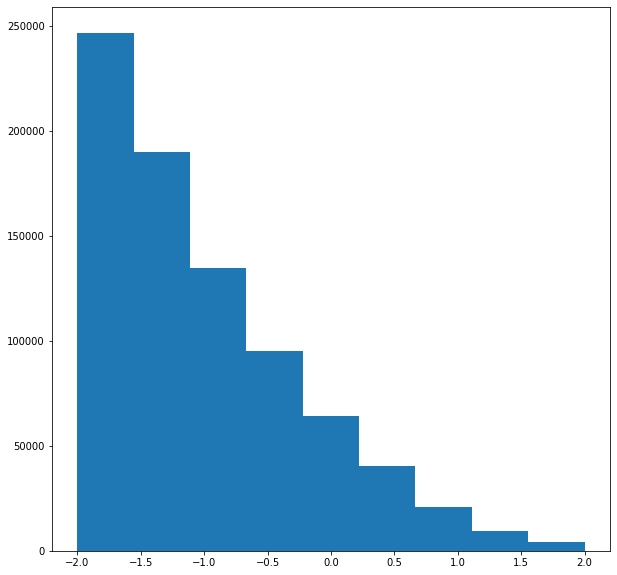

In [317]:
plt.hist(X_bb1[:,0],bins = np.linspace(-2,2,10))

In [318]:
(torch.tensor(dt[i * chunk_size:(i + 1) * chunk_size]) for i in range ) 

TypeError: 'type' object is not iterable

In [319]:
def get_loss(dt):
    
    chunk_size=5000 
    total_size=1000000
    i = 0
    i_max = total_size // chunk_size

    print(i_max)
    
    
    
    gen = (torch.tensor(dt[i*chunk_size: (i + 1) * chunk_size]) for i in range(i_max)) 

        
    with torch.no_grad():
        
        loss = [
            n
            for total_in_selection in gen
            for n in torch.mean((sigmodel(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
        ]
        
    return loss

In [287]:
def get_loss(dt):
    
    def generator(dt, chunk_size=5000, total_size=1000000):

        i = 0
        i_max = total_size // chunk_size
        print(i_max)
    
        for i in range(i_max):
            start=i * chunk_size
            stop=(i + 1) * chunk_size
            yield torch.tensor(dt[start:stop])
        
    loss = []

    
    with torch.no_grad():
        
        for total_in_selection in generator(dt,chunk_size=5000, total_size=1000000):
            loss.extend(torch.mean((sigmodel(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy())
    
    return loss

In [320]:
bb1_loss_sig = get_loss(X_bb1)

200


In [321]:
bb1_loss_sig = np.array(bb1_loss_sig,dtype=np.float)

In [322]:
print(bb1_loss_sig)

[1.90564466 0.96934295 1.35960376 ... 0.59359992 2.21692467 2.44283652]


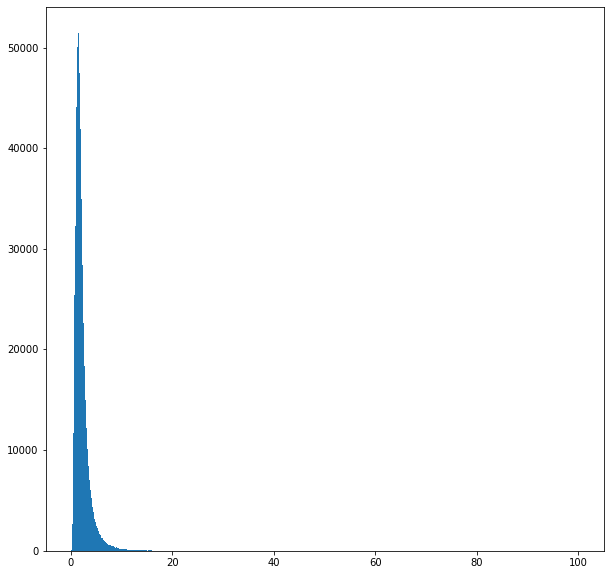

In [323]:
plt.hist(bb1_loss_sig,bins=np.linspace(0,100,1001));

In [324]:
np.save('../data_strings/sigaeloss_bb1.npy',bb1_loss_sig)

In [177]:
dt_3prong = f_3prong.values

In [178]:
Z = dt_3prong[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [179]:
Z.shape

(100000, 12)

In [180]:
for i in range(12):
    Z[:,i] = (Z[:,i]-sig_mean[i])/sig_std[i]

In [181]:
total_3prong = torch.tensor(Z)

In [199]:
bkgae_bkgloss = torch.mean((model(total_bkg_test.float().cuda())[0]- total_bkg_test.float().cuda())**2,dim=1).data.cpu().numpy()

In [ ]:
bkgae_3prongloss = torch.mean((model(total_3prong.float().cuda())[0]- total_3prong.float().cuda())**2,dim=1).data.cpu().numpy()

In [182]:
sigae_3prongloss = torch.mean((sigmodel(total_3prong.float().cuda())[0]- total_3prong.float().cuda())**2,dim=1).data.cpu().numpy()

In [183]:
sigae_3prongloss.shape

(100000,)

Text(0.5, 0, 'Signal AE Loss')

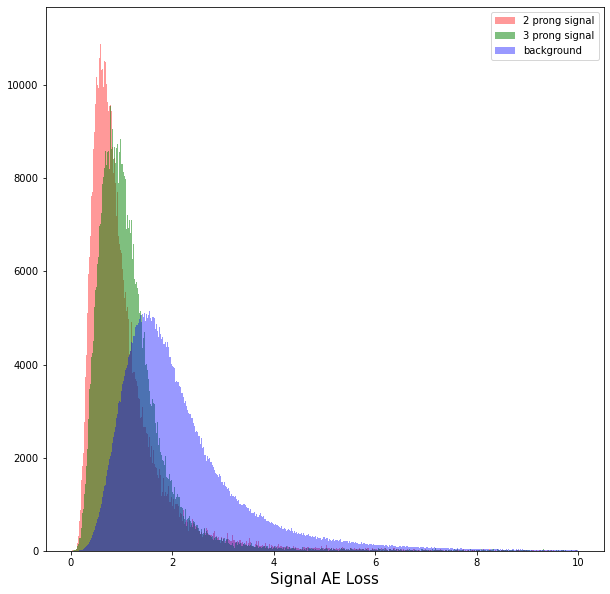

In [216]:
bins = np.linspace(0,10,1001)
plt.hist(sigae_sigloss,bins,weights = np.ones(len(signal_idx))*10,alpha=0.4,color='r',label='2 prong signal');
plt.hist(sigae_3prongloss,bins,weights = np.ones(100000)*10,alpha=0.5,color='g',label='3 prong signal');
plt.hist(sigae_bkgloss,bins,alpha=0.4,color='b',label='background');
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='upper right')
plt.xlabel('Signal AE Loss',fontsize=15)



In [193]:
def get_tpr_fpr(sigloss,bkgloss,aetype='sig'):
    bins = np.linspace(0,50,1001)
    tpr = []
    fpr = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
    return tpr,fpr      

In [194]:
def get_precision_recall(sigloss,bkgloss,aetype='bkg'):
    bins = np.linspace(0,100,1001)
    tpr = []
    fpr = []
    precision = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss<cut)[0].shape[0])/(np.where(bkgloss<cut)[0].shape[0]+np.where(sigloss<cut)[0].shape[0]))
            
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss>cut)[0].shape[0])/(np.where(bkgloss>cut)[0].shape[0]+np.where(sigloss>cut)[0].shape[0]))
    return precision,tpr      

In [196]:
tpr_2prong, fpr_2prong = get_tpr_fpr(sigae_sigloss,sigae_bkgloss,'sig')
tpr_3prong, fpr_3prong = get_tpr_fpr(sigae_3prongloss,sigae_bkgloss,'sig')

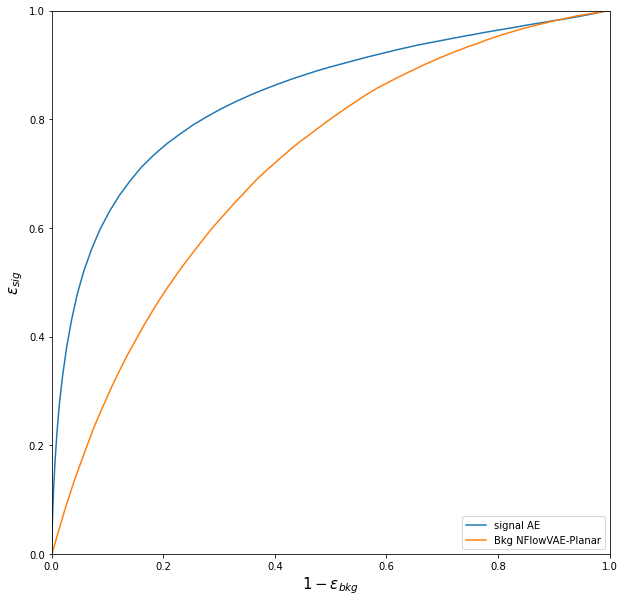

In [217]:
plt.plot(fpr_2prong,tpr_2prong,label='signal AE')
#plt.plot(VAE_bkg_fpr,VAE_bkg_tpr,label='Bkg VAE-Vanilla')
plt.plot(bkg_fpr4,bkg_tpr4,label='Bkg NFlowVAE-Planar')

plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.savefig('ROC_Curve_sigae.png')

In [ ]:
precision,recall = get_precision_recall(loss_sig,loss_bkg,aetype='bkg')

In [ ]:
np.save('NFLOWVAE_PlanarNEW_22var_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_22var_bkgloss.npy',loss_bkg)

In [ ]:
np.save('NFLOWVAE_PlanarNEW_precision.npy',precision)
np.save('NFLOWVAE_PlanarNEW_recall.npy',recall)
np.save('NFLOWVAE_PlanarNEW_bkgAE_fpr.npy',bkg_fpr)
np.save('NFLOWVAE_PlanarNEW_bkgAE_tpr.npy',bkg_tpr)
np.save('NFLOWVAE_PlanarNEW_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_bkgloss.npy',loss_bkg)

In [ ]:
plt.plot(recall,precision)

In [ ]:
flows = [1,2,3,4,5,6]
zdim = [1,2,3,4,5]

for N_flows in flows:
    for Z_DIM in zdim:
        model = VAE_NF(N_FLOWS, Z_DIM).cuda()
        optimizer = optim.Adam(model.parameters(), lr=LR)
        BEST_LOSS = 99999
        LAST_SAVED = -1
        PATIENCE_COUNT = 0
        PATIENCE_LIMIT = 5
        for epoch in range(1, N_EPOCHS):
            print("Epoch {}:".format(epoch))
            train()
            cur_loss = evaluate()

            if cur_loss <= BEST_LOSS:
                PATIENCE_COUNT = 0
                BEST_LOSS = cur_loss
                LAST_SAVED = epoch
                print("Saving model!")
                if mode == 'ROC':
                    torch.save(model.state_dict(),f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_RND_22var_z{Z_DIM}_f{N_FLOWS}.h5")
                else:
                    torch.save(model.state_dict(), f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_PureBkg_22var_z{Z_DIM}_f{N_FLOWS}.h5")
            else:
                PATIENCE_COUNT += 1
                print("Not saving model! Last saved: {}".format(LAST_SAVED))
                if PATIENCE_COUNT > 3:
                    print("Patience Limit Reached")
                    break 
                    
        loss_bkg = get_loss(dt_PureBkg[bkg_idx])
        loss_sig = get_loss(dt_PureBkg[signal_idx])
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_sigloss.npy',loss_sig)
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_bkgloss.npy',loss_bkg)